# Document Classification 

Skip down to the *Save Cleaned Corpus* section to load the data. I removed the intermediate data sets because they were so large. That particular step will load in the cleaned corpus dataframe. If you wish to run this initial section, then you need to download the original csv files from [here](https://www.kaggle.com/snapcrack/all-the-news).

In [5]:
import glob
import os
import re
import string

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [60]:
# Global Variables
MAX_NGRAM_LENGTH = 1
MAX_VECTOR = 5000
SET_RANDOM = 42

# Data Ingest & EDA

In [25]:
data_files = glob.glob(os.path.join("data", "*.csv"))

df = pd.concat([pd.read_csv(f) for f in data_files], ignore_index=True)
df.shape

(142570, 10)

In [26]:
df.columns

Index(['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year',
       'month', 'url', 'content'],
      dtype='object')

In [27]:
# Drop random columns
df.drop(labels=["Unnamed: 0", "url"], inplace=True, axis=1)
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [31]:
# Check publication counts
p_cnt = (
    df.groupby(["publication"])
    .agg(count=pd.NamedAgg("publication", "count"))
    .reset_index()
)

p_cnt

,publication,count
0,Atlantic,7179
1,Breitbart,23781
2,Business Insider,6757
3,Buzzfeed News,4854
4,CNN,11488
5,Fox News,4354
6,Guardian,8681
7,NPR,11992
8,National Review,6203
9,New York Post,17493


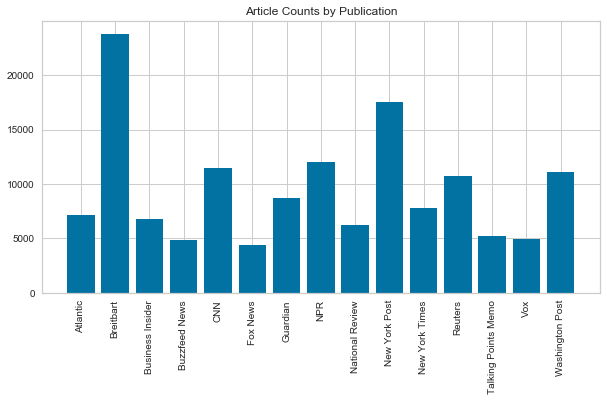

In [42]:
# Plot publication counts
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(p_cnt["publication"], p_cnt["count"])
ax.set_title("Article Counts by Publication")
plt.xticks(rotation="vertical")

plt.show()

### Pre-Process Corpus

In [43]:
# Regex for removing punctuation
re_punc = re.compile("[%s]" % re.escape(string.punctuation))


# Tokenize text and join back as one string
def tokenize_txt(txt: str):
    tok = word_tokenize(txt)
    tok = [w.lower() for w in tok]
    tok = [re_punc.sub("", w) for w in tok]
    tok = [word for word in tok if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    tok = [w for w in tok if w not in stop_words]
    return " ".join(tok)

In [45]:
df["c_content"] = df["content"].apply(tokenize_txt)

### Save Cleaned Corpus  
Skip to this point to load the cleaned corpus on successive runs of the notebook. Uncomment / comment the following two lines as needed.

In [119]:
df.to_csv(path_or_buf="data/news_corpus.csv")
df = pd.read_csv("data/news_corpus.csv")

Let's drop some of the publications so that we are working with a smaller sample with less classes.

In [120]:
# take top 5 classes
df = df.loc[df.publication.isin(["Breitbart", "New York Post", "Washington Post", "CNN", "Fox"])]
df.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
df.dropna(subset=["c_content"], inplace=True)
df.reset_index(inplace=True)
df.shape

(63873, 10)

In [121]:
# Review publication distribution
df.groupby(["publication"]).agg(pub_count=pd.NamedAgg("publication", "count"))

,pub_count
publication,
Breitbart,23781
CNN,11485
New York Post,17493
Washington Post,11114


### Train-Test Split

In [122]:
x_data = df[["id", "c_content"]]
y_data = df["publication"]

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=SET_RANDOM)

# Validate the splits
print("x-train = {}".format(x_train.shape))
print("x-test = {}".format(x_test.shape))
print("y-train = {}".format(len(y_train)))
print("y-test = {}".format(len(y_test)))

x-train = (44711, 2)
x-test = (19162, 2)
y-train = 44711
y-test = 19162


# Count Vectorized  

### Fit the Count Vectorizer and Transform Corpus

In [123]:
# Instantiate the Count Vectorizer Class
count_vect = CountVectorizer(
    ngram_range=(1, MAX_NGRAM_LENGTH), 
    max_features=MAX_VECTOR, 
)

# Fit & Transform on training data
count_vect.fit(x_train["c_content"])
count_vector = count_vect.transform(x_train["c_content"])

# Transform Test data
count_test_vector = count_vect.transform(x_test["c_content"])

In [124]:
print("Train count vector shape = {}".format(count_vector.shape))
print("Test count vector shape = {}".format(count_test_vector.shape))

Train count vector shape = (44711, 5000)
Test count vector shape = (19162, 5000)


In [125]:
wc = {
    "word": [],
    "corpus_count": [],
}

for k, v in count_vect.vocabulary_.items():
    wc["word"].append(k)
    wc["corpus_count"].append(v)

wc_df = pd.DataFrame(wc).sort_values(by="corpus_count", ascending=False)
wc_df.head(10)

,word,corpus_count
2980,zuckerberg,4999
3019,zones,4998
3407,zone,4997
4433,zika,4996
4900,zero,4995
4702,youtube,4994
4313,youth,4993
2736,younger,4992
309,young,4991
3076,yorkers,4990


### Save Term-Document Matrix

In [ ]:
count_df = pd.DataFrame(
    count_vector.toarray(),
    columns=count_vect.vocabulary_.keys(),
    index=x_train["id"]
)

# Write to disk
count_df.to_csv("data/count_term_doc_matrix.csv")

### Random Forest Classification

/Users/jasonadam/.local/share/virtualenvs/news-nlp-unJIfvp2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


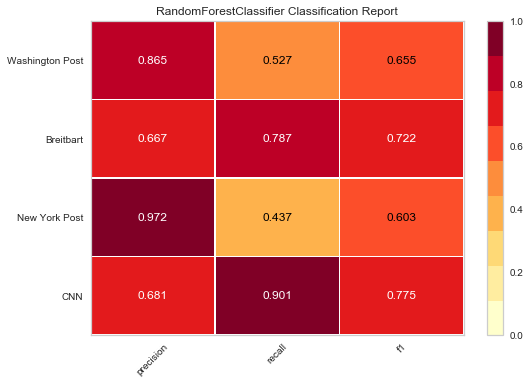

In [126]:
# Instantiate Model
count_clf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=SET_RANDOM, n_jobs=-1
)

viz_report_count = ClassificationReport(count_clf, classes=y_train.unique())
viz_report_count.fit(count_vector, y_train)
viz_report_count.score(count_test_vector, y_test)
viz_report_count.show()

/Users/jasonadam/.local/share/virtualenvs/news-nlp-unJIfvp2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


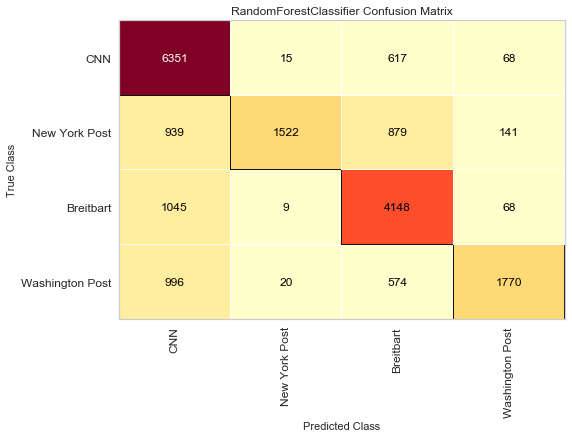

In [127]:
cm_count = ConfusionMatrix(count_clf, classes=y_train.unique())
cm_count.fit(count_vector, y_train)
cm_count.score(count_test_vector, y_test)
cm_count.show()

# TF-IDF  

### Fit the TF-IDF Vectorizer & Transform Corpus

In [128]:
# Instantiate TFIDF Vectorizer & fit to cleaned docs
tfidf_vect = TfidfVectorizer(
    ngram_range=(1, MAX_NGRAM_LENGTH), 
    max_features=MAX_VECTOR
)

# Run fit & transform
tfidf_vect.fit(x_train["c_content"])
tfidf_vector = tfidf_vect.transform(x_train["c_content"])

# Run Transform on test data
tfidf_test_vector = tfidf_vect.transform(x_test["c_content"])

In [129]:
print("Train tfidf vector shape = {}".format(tfidf_vector.shape))
print("Test tfidf vector shape = {}".format(tfidf_test_vector.shape))

Train tfidf vector shape = (44711, 5000)
Test tfidf vector shape = (19162, 5000)


### Save Term-Document Matrix

In [131]:
tfidf_df = pd.DataFrame(
    tfidf_vector.toarray(), 
    columns=tfidf_vect.vocabulary_.keys(), 
    index=x_train["id"]
)

# Write to disk
tfidf_df.to_csv("data/tfidf_term_doc_matrix.csv")

### Random Forest Classification

/Users/jasonadam/.local/share/virtualenvs/news-nlp-unJIfvp2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


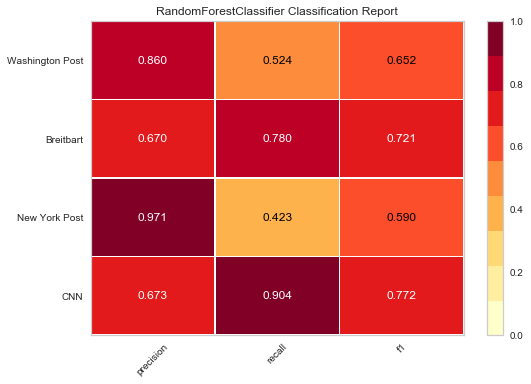

In [133]:
# Instantiate Model
tfidf_clf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=SET_RANDOM, n_jobs=-1
)

viz_report = ClassificationReport(tfidf_clf, classes=y_train.unique())
viz_report.fit(tfidf_vector, y_train)
viz_report.score(tfidf_test_vector, y_test)
viz_report.show()

/Users/jasonadam/.local/share/virtualenvs/news-nlp-unJIfvp2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


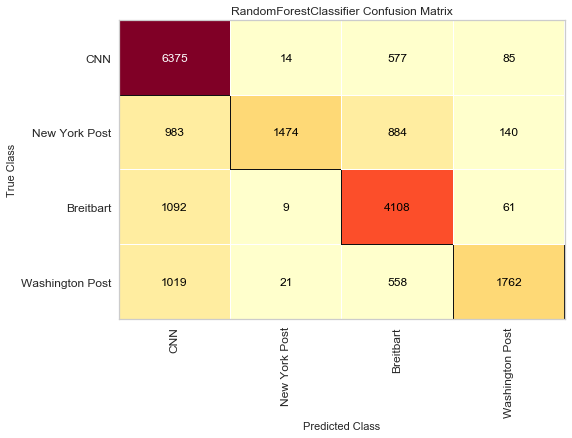

In [134]:
cm = ConfusionMatrix(tfidf_clf, classes=y_train.unique())
cm.fit(tfidf_vector, y_train)
cm.score(tfidf_test_vector, y_test)
cm.show()

# Doc2Vec (50 Dimensions)  

### Create Embeddings  
Due to the extremely long time needed on my local computer to train the embeddings, I only trained embeddings with 50 dimensions.

In [137]:
# Create list of words from document
def create_gensim_tagged_doc(df: pd.DataFrame) -> list:
    tokens = [doc.split() for doc in df["c_content"]]
    return tokens, [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]

In [138]:
# Prep train and test
train_tokens, train_corp = create_gensim_tagged_doc(x_train)
test_tokens, test_corp = create_gensim_tagged_doc(x_test)

In [139]:
# Instantiate the model
model_50 = Doc2Vec(
    train_corp, vector_size=50, min_count=2, epochs=50, seed=SET_RANDOM
)

In [140]:
# Train model
model_50.train(
    train_corp, total_examples=model_50.corpus_count, epochs=model_50.epochs
)

In [141]:
# Populate numpy array
model_50_vectors = np.zeros((len(train_tokens), 50))
for i in range(0, len(train_tokens)):
    model_50_vectors[i, ] = model_50.infer_vector(train_tokens[i]).transpose()

# Test
model_50_vectors_test = np.zeros((len(test_tokens), 50))
for i in range(0, len(test_tokens)):
    model_50_vectors_test[i, ] = model_50.infer_vector(test_tokens[i]).transpose()

In [142]:
print("Doc2Vec training shape = {}".format(model_50_vectors.shape))
print("Doc2Vec testing shape = {}".format(model_50_vectors_test.shape))

Doc2Vec training shape = (44711, 50)
Doc2Vec testing shape = (19162, 50)


### Save Embeddings

In [143]:
mod_50_dim = pd.DataFrame(
    model_50_vectors,
    index=x_train["id"]
)

mod_50_dim.to_csv("data/embeddings_50_dim.csv")

### Random Forest Classification

/Users/jasonadam/.local/share/virtualenvs/news-nlp-unJIfvp2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


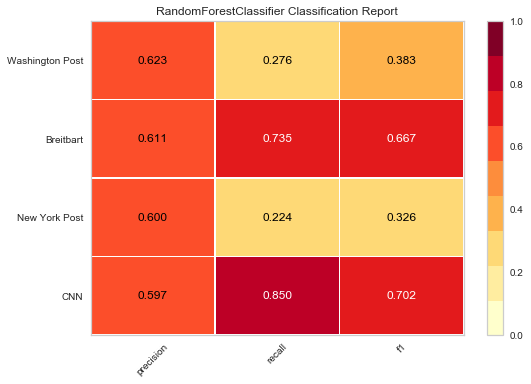

In [145]:
# Instantiate Model
d2v50_clf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=SET_RANDOM, n_jobs=-1
)

viz_report_d2v50 = ClassificationReport(d2v50_clf, classes=y_train.unique())
viz_report_d2v50.fit(model_50_vectors, y_train)
viz_report_d2v50.score(model_50_vectors_test, y_test)
viz_report_d2v50.show()

/Users/jasonadam/.local/share/virtualenvs/news-nlp-unJIfvp2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


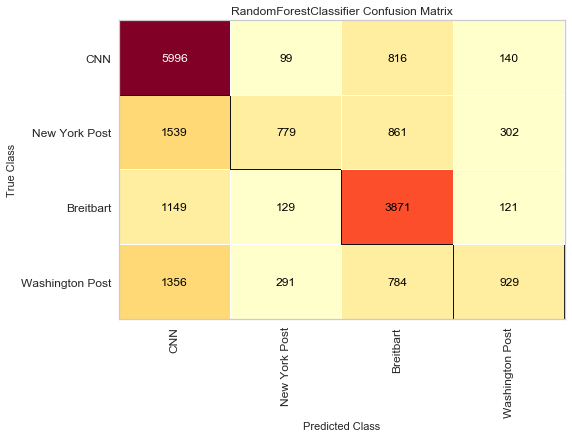

In [146]:
cm_d2v50 = ConfusionMatrix(d2v50_clf, classes=y_train.unique())
cm_d2v50.fit(model_50_vectors, y_train)
cm_d2v50.score(model_50_vectors_test, y_test)
cm_d2v50.show()

# Summary

In [148]:
summary_df = pd.DataFrame(
    {
        "Model": ["CountVectorizer", "TF-IDF", "Doc2Vec_50_Dim"],
        "RandomForestAccuracy": [
            viz_report_count.score_,
            viz_report.score_,
            viz_report_d2v50.score_,
        ],
    }
)

summary_df

,Model,RandomForestAccuracy
0,CountVectorizer,0.719706
1,TF-IDF,0.715948
2,Doc2Vec_50_Dim,0.604060
